In [1]:
import numpy as np
import scipy as scipy
from scipy import optimize, linalg
from scipy.stats import qmc
from matplotlib import pyplot as plt
import scipy.stats as sps
import os
import datetime
import time

from itertools import repeat

plt.style.use('science')
plt.rcParams.update({'font.size': 24})

# import rmf_rbm
import rmf_rbm_hybrid as rmf_rbm
# import rmf_rbm_fort

import pandas as pd

from surmise.emulation import emulator
from surmise.calibration import calibrator

DTYPE = np.float64

from multiprocessing import Pool

import corner

In [2]:
def NM_to_RMF(params):

      #rmf_params = np.zeros(params.shape)

      hbarc = 197.32698
      mn = 939.0/hbarc
      ms = params[0]/hbarc
      mv = 782.500/hbarc
      mr = 763.00/hbarc
      kf = params[1]
      eb = params[2]/hbarc
      mstar = params[3]*mn
      K = params[4]/hbarc
      zeta = params[5]
      J = params[6]/hbarc
      L = params[7]/hbarc   
      m=mstar                                         #simple notation
      ef=np.sqrt(kf**2+m**2)                             #Fermi energy
      logk=np.log((kf+ef)/m)                             #useful log.
      rhov=(2*kf**3)/(3*np.pi**2)                        #vector density
      rhos=(m*kf*ef-m**3*logk)/np.pi**2                  #scalar density
      rhosp=(kf*(ef**2+2*m**2)/ef-3*m**2*logk)/np.pi**2  #scalar density' 
      edens=(kf*ef*(kf**2+ef**2)-m**4*logk)/(4*np.pi**2) #energy density      
      ef=np.sqrt(kf**2+mstar**2)               #Fermi energy
      en=eb+mn                              #nucleon energy
      W0=en-ef                              #vector potential
      gv2=mv**2/(rhov/W0-zeta*W0**2/6)      #coupling constant    
      ef=np.sqrt(kf**2+mstar**2)                   #Fermi energy
      en=eb+mn                                  #nucleon energy
      W0=en-ef                                  #vector potential
      gv2=mv**2/(rhov/W0-zeta*W0**2/6)          #coupling constant
      mvs2=mv**2+0.5*zeta*gv2*W0**2        #effective omega mass
      #Solve for scalar couplings:
      P0=mn-mstar                               #scalar potential
      #Compute the A-matrix
      A11=P0**2/2                               #A(1,1)
      A12=P0**3/6                               #A(1,2)
      A13=P0**4/24                              #A(1,3)
      A21=P0                                    #A(2,1)
      A22=P0**2/2                               #A(2,2)
      A23=P0**3/6                               #A(2,3)
      A31=1.0                             #A(3,1)
      A32=P0                                    #A(3,2)
      A33=P0**2/2                               #A(3,3)
      #Compute the B-vector:
      B1f=+en*rhov-edens                        #B1nucleons
      B1m=-(mv*W0)**2/(2*gv2)-zeta*W0**4/8      #B1mesons
      B3n=(mstar/ef)**2                         #B3numerator
      B3d=kf**2/(3*ef*rhov)+gv2/mvs2-K/(9*rhov) #B3denominator
      B1=B1f+B1m                                #B(1)
      B2=rhos                                   #B(2)
      B3=B3n/B3d-rhosp                          #B(3)
      #Compute the Inverse of A (call it M):
      Determ=A11*(A22*A33-A23*A32) \
           -A21*(A12*A33-A13*A32) \
           +A31*(A12*A23-A13*A22)
      M11=+(A22*A33-A23*A32)/Determ             #M(1,1) 
      M12=-(A12*A33-A13*A32)/Determ             #M(1,2)
      M13=+(A12*A23-A13*A22)/Determ             #M(1,3)
      M21=-(A21*A33-A23*A31)/Determ             #M(2,1)
      M22=+(A11*A33-A13*A31)/Determ             #M(2,2) 
      M23=-(A11*A23-A13*A21)/Determ             #M(2,3) 
      M31=+(A21*A32-A22*A31)/Determ             #M(3,1) 
      M32=-(A11*A32-A12*A31)/Determ             #M(3,2) 
      M33=+(A11*A22-A12*A21)/Determ             #M(3,3) 
      #Compute coupling constants:
      C1=M11*B1+M12*B2+M13*B3                   #C(1)
      C2=M21*B1+M22*B2+M23*B3                   #C(2)
      C3=M31*B1+M32*B2+M33*B3                   #C(3)
      gs2=ms**2/C1                              #gs2
      gs=np.sqrt(gs2)                              #gs
      kappa=C2                                  #kappa (in fm^-1)
      lamb=C3                                 #lambda 
      P0=mn-mstar                                       #Phi0=M-M*
      mss2=ms**2+kappa*gs2*P0+lamb*gs2*P0**2/2        #(ms*)^2
      Css2=gs2/mss2                                     #(Cs*)^2
      #Compute (Cv*)^2:
      ef=np.sqrt(kf**2+mstar**2)                           #Fermi energy
      en=eb+mn                                          #E/N
      W0=en-ef                                          #W0=gv*V0
      mvs2=mv**2+zeta*gv2*W0**2/2                       #(mv*)^2
      Cvs2=gv2/mvs2                                     #(Cv*)^2  
      #Compute quantity "xi":
      xi=(3*rhov/ef)/((1/Css2)+rhosp)                   #useful quantity      
      #Extract isovector parameters:
      J1=kf**2/(6*ef)                                   #isoscalar contribution to J             
      L1=J1*(1+(mstar/ef)**2*(1+xi))                    #isoscalar contribution to L
      J2=J-J1
      L2=L-L1
      Crs2=8*J2/rhov                                #(Cr*)^2
      Lambdav=(3*J2-L2)/(96*J2**2*Cvs2*W0)
      gr2=(Crs2*mr**2)/(1-2*Lambdav*Crs2*W0**2)

      rmf_params = np.array([ms, np.sqrt(gs2), np.sqrt(gv2), np.sqrt(gr2), kappa, lamb, zeta, Lambdav])
    #   if(gs2<0.0 or gv2<0.0 or gr2<0.0):
    #     print("Negative! ",gs2,gv2,gr2,(1-2*Lambdav*Crs2*W0**2))
    #     print(params)
      return rmf_params

def rbm_driver(x, theta):
    if(theta.shape[0] < -1):
        y = rbm_multi_theta(x, theta)
    else:
        y = rbm_emulator(x, theta)
    return y

def rbm_multi_theta(x, theta):
    print("Multi: ",theta.shape)
    with Pool(12) as p:
        y_samp = p.map(rbm_emulator_all,theta)
        #print(y[0],y[1])
    return np.asarray(y_samp).T


def rbm_emulator_all(theta):
    #print(x.shape)
    ytmp = np.zeros((18,))
    pstates = [3, 6, 6, 7,  10, 11, 11, 11, 13, 16]
    nstates = [3, 6, 7, 10, 11, 11, 14, 16, 16, 22]
    A = [16, 40, 48, 68, 90, 100, 116, 132, 144, 208]
    func = [rmf_rbm.rmf_poly_16O_0,
        rmf_rbm.rmf_poly_40Ca_0,
        rmf_rbm.rmf_poly_48Ca_0,
        rmf_rbm.rmf_poly_68Ni_0,
        rmf_rbm.rmf_poly_90Zr_0,
        rmf_rbm.rmf_poly_100Sn_0,
        rmf_rbm.rmf_poly_116Sn_0,
        rmf_rbm.rmf_poly_132Sn_0,
        rmf_rbm.rmf_poly_144Sm_0,
        rmf_rbm.rmf_poly_208Pb_0,
        ]

    jacfunc = [rmf_rbm.rmf_poly_16O_0_jac,
            rmf_rbm.rmf_poly_40Ca_0_jac,
            rmf_rbm.rmf_poly_48Ca_0_jac,
            rmf_rbm.rmf_poly_68Ni_0_jac,
            rmf_rbm.rmf_poly_90Zr_0_jac,
            rmf_rbm.rmf_poly_100Sn_0_jac,
            rmf_rbm.rmf_poly_116Sn_0_jac,
            rmf_rbm.rmf_poly_132Sn_0_jac,
            rmf_rbm.rmf_poly_144Sm_0_jac,
            rmf_rbm.rmf_poly_208Pb_0_jac,
            ]

    nucenergy_func=[rmf_rbm.nucleon_energy_16O_0,
                    rmf_rbm.nucleon_energy_40Ca_0,
                    rmf_rbm.nucleon_energy_48Ca_0,
                    rmf_rbm.nucleon_energy_68Ni_0,
                    rmf_rbm.nucleon_energy_90Zr_0,
                    rmf_rbm.nucleon_energy_100Sn_0,
                    rmf_rbm.nucleon_energy_116Sn_0,
                    rmf_rbm.nucleon_energy_132Sn_0,
                    rmf_rbm.nucleon_energy_144Sm_0,
                    rmf_rbm.nucleon_energy_208Pb_0,
                    ]
    fldenergy_func=[rmf_rbm.field_energy_16O_0,
                    rmf_rbm.field_energy_40Ca_0,
                    rmf_rbm.field_energy_48Ca_0,
                    rmf_rbm.field_energy_68Ni_0,
                    rmf_rbm.field_energy_90Zr_0,
                    rmf_rbm.field_energy_100Sn_0,
                    rmf_rbm.field_energy_116Sn_0,
                    rmf_rbm.field_energy_132Sn_0,
                    rmf_rbm.field_energy_144Sm_0,
                    rmf_rbm.field_energy_208Pb_0,
                    ]
    protonrad_func=[rmf_rbm.proton_radius_16O_0,
                    rmf_rbm.proton_radius_40Ca_0,
                    rmf_rbm.proton_radius_48Ca_0,
                    rmf_rbm.proton_radius_68Ni_0,
                    rmf_rbm.proton_radius_90Zr_0,
                    rmf_rbm.proton_radius_100Sn_0,
                    rmf_rbm.proton_radius_116Sn_0,
                    rmf_rbm.proton_radius_132Sn_0,
                    rmf_rbm.proton_radius_144Sm_0,
                    rmf_rbm.proton_radius_208Pb_0,
                    ]
    rmf_param = NM_to_RMF(theta)
    nbasis = [55, 105, 115, 149, 177, 186, 208, 234, 242, 316]
    missing = 0
    for nuc in range(10):

        x0 = np.zeros((nbasis[nuc]))
        
        sol = optimize.root(func[nuc], x0, args=(rmf_param), jac=jacfunc[nuc], method="hybr", options={'col_deriv': 1, 'xtol': 1e-8})


        if(nuc!=3 and nuc!=5):
            ytmp[2*nuc  -missing] = np.sqrt(protonrad_func[nuc](sol.x, rmf_param))
        else:
            missing += 1
        ytmp[2*nuc+1-missing] = (nucenergy_func[nuc](sol.x, rmf_param) - \
             fldenergy_func[nuc](sol.x, rmf_param))/A[nuc] + 0.75*41*A[nuc]**(-4.0/3.0)
    
    #print(y[0],y[1])
    return ytmp

def rbm_emulator(x,theta):
    # ytrue = np.array([2.70,7.98,
    #           3.48,8.55,
    #           3.48,8.67,
    #           8.68,
    #           4.27,8.71,
    #           8.25,
    #           4.63,8.52,
    #           4.71,8.36,
    #           4.95,8.30,
    #           5.50,7.87,
    #           ])
    #print(theta.shape)
    ytmp = np.zeros((20,))
    A = [16, 40, 48, 68, 90, 100, 116, 132, 144, 208]
    nbasis = [55, 105, 115, 149, 177, 186, 208, 234, 242, 316]

    func = [rmf_rbm.rmf_poly_16O_0,
        rmf_rbm.rmf_poly_40Ca_0,
        rmf_rbm.rmf_poly_48Ca_0,
        rmf_rbm.rmf_poly_68Ni_0,
        rmf_rbm.rmf_poly_90Zr_0,
        rmf_rbm.rmf_poly_100Sn_0,
        rmf_rbm.rmf_poly_116Sn_0,
        rmf_rbm.rmf_poly_132Sn_0,
        rmf_rbm.rmf_poly_144Sm_0,
        rmf_rbm.rmf_poly_208Pb_0,
        ]

    jacfunc = [rmf_rbm.rmf_poly_16O_0_jac,
            rmf_rbm.rmf_poly_40Ca_0_jac,
            rmf_rbm.rmf_poly_48Ca_0_jac,
            rmf_rbm.rmf_poly_68Ni_0_jac,
            rmf_rbm.rmf_poly_90Zr_0_jac,
            rmf_rbm.rmf_poly_100Sn_0_jac,
            rmf_rbm.rmf_poly_116Sn_0_jac,
            rmf_rbm.rmf_poly_132Sn_0_jac,
            rmf_rbm.rmf_poly_144Sm_0_jac,
            rmf_rbm.rmf_poly_208Pb_0_jac,
            ]

    nucenergy_func=[rmf_rbm.nucleon_energy_16O_0,
                    rmf_rbm.nucleon_energy_40Ca_0,
                    rmf_rbm.nucleon_energy_48Ca_0,
                    rmf_rbm.nucleon_energy_68Ni_0,
                    rmf_rbm.nucleon_energy_90Zr_0,
                    rmf_rbm.nucleon_energy_100Sn_0,
                    rmf_rbm.nucleon_energy_116Sn_0,
                    rmf_rbm.nucleon_energy_132Sn_0,
                    rmf_rbm.nucleon_energy_144Sm_0,
                    rmf_rbm.nucleon_energy_208Pb_0,
                    ]
    fldenergy_func=[rmf_rbm.field_energy_16O_0,
                    rmf_rbm.field_energy_40Ca_0,
                    rmf_rbm.field_energy_48Ca_0,
                    rmf_rbm.field_energy_68Ni_0,
                    rmf_rbm.field_energy_90Zr_0,
                    rmf_rbm.field_energy_100Sn_0,
                    rmf_rbm.field_energy_116Sn_0,
                    rmf_rbm.field_energy_132Sn_0,
                    rmf_rbm.field_energy_144Sm_0,
                    rmf_rbm.field_energy_208Pb_0,
                    ]
    protonrad_func=[rmf_rbm.proton_radius_16O_0,
                    rmf_rbm.proton_radius_40Ca_0,
                    rmf_rbm.proton_radius_48Ca_0,
                    rmf_rbm.proton_radius_68Ni_0,
                    rmf_rbm.proton_radius_90Zr_0,
                    rmf_rbm.proton_radius_100Sn_0,
                    rmf_rbm.proton_radius_116Sn_0,
                    rmf_rbm.proton_radius_132Sn_0,
                    rmf_rbm.proton_radius_144Sm_0,
                    rmf_rbm.proton_radius_208Pb_0,
                    ]
    calibrate = []
    for thet in range(theta.shape[0]):
        #print(theta[thet])
        rmf_param = NM_to_RMF(theta[thet])
        # rmf_param = theta[thet]

        # with Pool(4) as p:
        #     sol_array = p.starmap(galerkin_helper,zip(func,jacfunc,nbasis,repeat(rmf_param)))
        #print(sol_array)
        for nuc in range(10):

            x0 = np.zeros((nbasis[nuc]))
            
            sol = optimize.root(func[nuc], x0, args=(rmf_param), jac=jacfunc[nuc], method="hybr", options={'col_deriv': 1, 'xtol': 1e-8})
            # sol = sol_array[nuc]
            ytmp[2*nuc ] = np.sqrt(protonrad_func[nuc](sol.x, rmf_param))
            #print(0.75*41*A[nuc]**(1.0/3.0))
            ytmp[2*nuc+1] = (nucenergy_func[nuc](sol.x, rmf_param) - \
                fldenergy_func[nuc](sol.x, rmf_param))/A[nuc] + 0.75*41*A[nuc]**(-4.0/3.0)
        y = ytmp.copy()
        calibrate.append([y[0],y[1],
                    y[2],y[3],
                    y[4],y[5],
                    y[7],
                    y[8],y[9],
                    y[11],
                    y[12],y[13],
                    y[14],y[15],
                    y[16],y[17],
                    y[18],y[19],
                    ])
        # print(np.asarray(calibrate[thet][:]) - ytrue)
    #print(y[0],y[1])
    # print(np.asarray(calibrate).shape)
    return np.asarray(calibrate).T

def galerkin_helper(func,jacfunc,nbasis,params):
    x0 = np.zeros((nbasis,))
        
    sol = optimize.root(func, x0, args=(params), jac=jacfunc, method="hybr", options={'col_deriv': 1, 'xtol': 1e-8})

    return sol

def calibration_runner(rbm,y,obsvar,test_params,numsamp,i,caldir):
    cal = calibrator(emu=rbm,
                   y=y,
                   #x=x,
                   thetaprior=prior_rmf, 
                   method='directbayes',
                   yvar=obsvar, 
                   args={
                        'theta0': test_params.reshape(1,8),
                        'sampler': 'metropolis_hastings',
                         'numsamp' : numsamp,
                         'stepType' : 'normal',
                         'stepParam' : 1e-1*np.array([0.5, 0.002, 0.02, 0.002, 0.2, 0.0005, 0.08, 1.16])})
                        #  'stepParam' : [1.0, 0.02, 0.04, 0.02, 0.2, 0.001, 0.2, 0.8]})
 
    calfile = os.path.join(caldir,"caltheta_{}.out".format(i))
    np.savetxt(calfile,cal.info['thetarnd'])

    return cal.info['thetarnd']


# Define prior
# Define a class for prior of 10 parameters
class prior_rmf:
    """ This defines the class instance of priors provided to the method. """
    #491.5, 782.5, 763.0,1.300007342, -16.300267889,   0.609994999, 230.015112825, 0.060000000,  32.592911754,  60.0
    # ms = [450,550] MeV
    # Rho0 = [0.14,0.16] fm^-3
    # E0 = [-17,-15] MeV
    # M*/M = [0.5,0.7]
    # K = [220,240] MeV
    # J = [30,38] MeV
    # L = [40,120] MeV
    # Zeta = [0,0.06]
    def lpdf(theta):
        return (sps.norm.logpdf(theta[:, 0], 500.0, 50.0) +
                # sps.norm.logpdf(theta[:, 1], 782.5, 0.5) + 
                # sps.norm.logpdf(theta[:, 2], 763.0, 0.5) + 
                sps.norm.logpdf(theta[:, 1], 1.300007342, 0.1) + 
                sps.norm.logpdf(theta[:, 2], -16.0, 1.0) + 
                sps.norm.logpdf(theta[:, 3], 0.6, 0.1) + 
                sps.norm.logpdf(theta[:, 4], 230.0, 10.0) + 
                sps.norm.logpdf(theta[:, 5], 0.03, 0.03) + 
                sps.norm.logpdf(theta[:, 6], 34.0, 4.0) + 
                sps.norm.logpdf(theta[:, 7], 80.0, 40.0)).reshape((len(theta), 1))


    def rnd(n):
        return np.vstack((sps.norm.rvs(500.0, 50.0,   size=n),
                        #   sps.norm.rvs(782.5, 0.5,   size=n),
                        #   sps.norm.rvs(763.0, 0.5,   size=n),
                          sps.norm.rvs(1.300007342, 0.1, size=n),
                          sps.norm.rvs(-16.0, 1.0,    size=n),
                          sps.norm.rvs(0.6, 0.1,    size=n),
                          sps.norm.rvs(230.0, 10.0,    size=n),
                          sps.norm.rvs(0.03, 0.03,    size=n),
                          sps.norm.rvs(34.0, 4.0,   size=n),
                          sps.norm.rvs(80.0, 40.0,   size=n))).T


In [37]:
df = pd.read_csv("Sampling.out", delim_whitespace=True)
print(df['L'].max())
print(df['L'].min())

# df = pd.read_csv("ParamsSampledWith2TimesSD.txt", delim_whitespace=True)
# print(df['L'].max())
# print(df['L'].min())

# df = pd.read_csv("ParamsSampledWith2TimesSDHalfCorrelation.txt", delim_whitespace=True)
# print(df['L'].max())
# print(df['L'].min())

samples = 100

test_params = np.array([491.51, 1.3, -16.4, 0.6, 230.0, 0.06, 32.5, 70.0]).reshape(1,8)

params = test_params.copy()

start = time.time()
for i in range(samples):
    params = np.vstack((params,test_params))

y=rbm_driver(x=None,theta=params)

    #test_params = np.array([2.52109, 10.3968, 13.5569, 10.5901, 0.0152179, -0.000533, 0.0256, 0.021417])

    # sol = optimize.root(rmf_rbm.rmf_poly_208Pb_0,np.zeros((316)),args=(test_params,))
end = time.time()
# print(sol)
print(end - start, "total seconds")
print((end - start)/samples, "seconds per sample")


212.85938943042177
4.749594863617304
Multi:  (101, 8)
3.995542287826538 total seconds
0.03995542287826538 seconds per sample


In [26]:
#n=100
#theta = prior_rmf.rnd(n)
#theta_range = np.array([35, 120])

test_params = np.array([491.51, 1.3, -16.4, 0.6, 230.0, 0.06, 32.5, 70.0])

x = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])

rbm = emulator(x=x, theta=test_params, passthroughfunc=rbm_driver)

y = np.array([2.70,7.976206,
              3.48,8.551303,
              3.48,8.666689,
              8.68247,
              4.27,8.70998,
              8.25300,
              4.63,8.523116,
              4.71,8.354852,
              4.95,8.303678,
              5.50,7.86745,
              ])
yerr = np.array([0.0134,0.0028,
              0.0034,0.0014,
              0.0027,0.0042,
              0.0007,
              0.0019,0.0028,
              0.0028,
              0.0043,0.0039,
              0.0007,0.0008,
              0.0026,0.00005,
              0.0018,0.0018,
              ])
obsvar = np.maximum(1.0*np.square(y*yerr),1e-5)
print(y,obsvar)
# obsvar = np.maximum(0.2*y, 0.1)
# obsvar = y*1e-5
# Fit a calibrator with emulator 1 via via method = 'directbayes' and 'sampler' = 'metropolis_hastings' 
cal_1 = calibrator(emu=rbm,
                   y=y,
                   #x=x,
                   thetaprior=prior_rmf, 
                   method='directbayes',
                   yvar=obsvar, 
                   args={
                        'theta0': test_params.reshape(1,8),
                        'sampler': 'metropolis_hastings',
                         'numsamp' : 1000,
                         'stepType' : 'normal',
                         'stepParam' : [1.0, 0.002, 0.02, 0.002, 0.2, 0.0005, 0.08, 0.8]})



[2.7      7.976206 3.48     8.551303 3.48     8.666689 8.68247  4.27
 8.70998  8.253    4.63     8.523116 4.71     8.354852 4.95     8.303678
 5.5      7.86745 ] [1.30899240e-03 4.98779719e-04 1.39996224e-04 1.43324575e-04
 8.82848160e-05 1.32496683e-03 3.69387898e-05 6.58207690e-05
 5.94771813e-04 5.33998151e-04 3.96368281e-04 1.10490773e-03
 1.08702090e-05 4.46742732e-05 1.65636900e-04 1.00000000e-05
 9.80100000e-05 2.00545533e-04]
Multi:  (100, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)
(1, 8)

(8,)
[ 4.97752190e+02  1.30439503e+00 -1.61960030e+01  6.14683849e-01
  2.28862141e+02  5.63986146e-02  3.35439509e+01  7.22065683e+01]
[3.47198465e-01 9.98050307e-07 1.51848399e-04 5.81371735e-07
 2.28562243e-01 1.88208191e-07 6.47191257e-03 2.81117163e-01]
Multi:  (1000, 8)


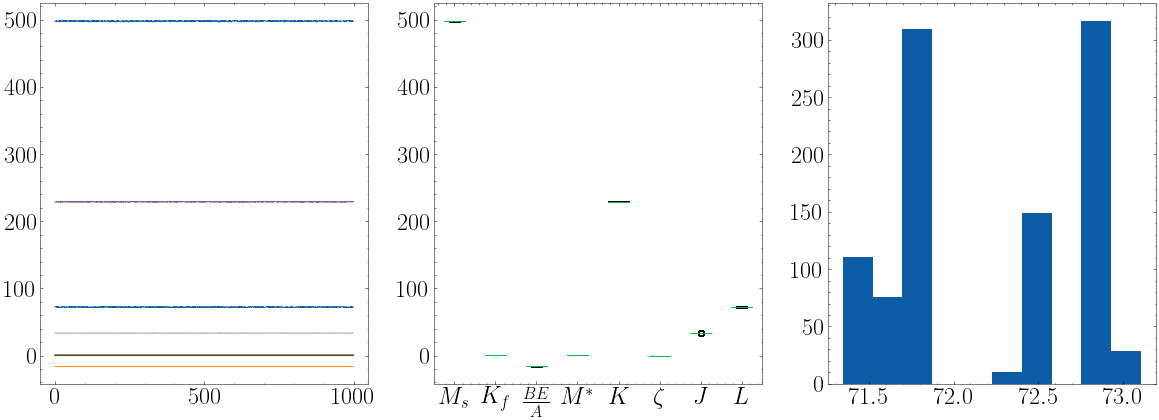

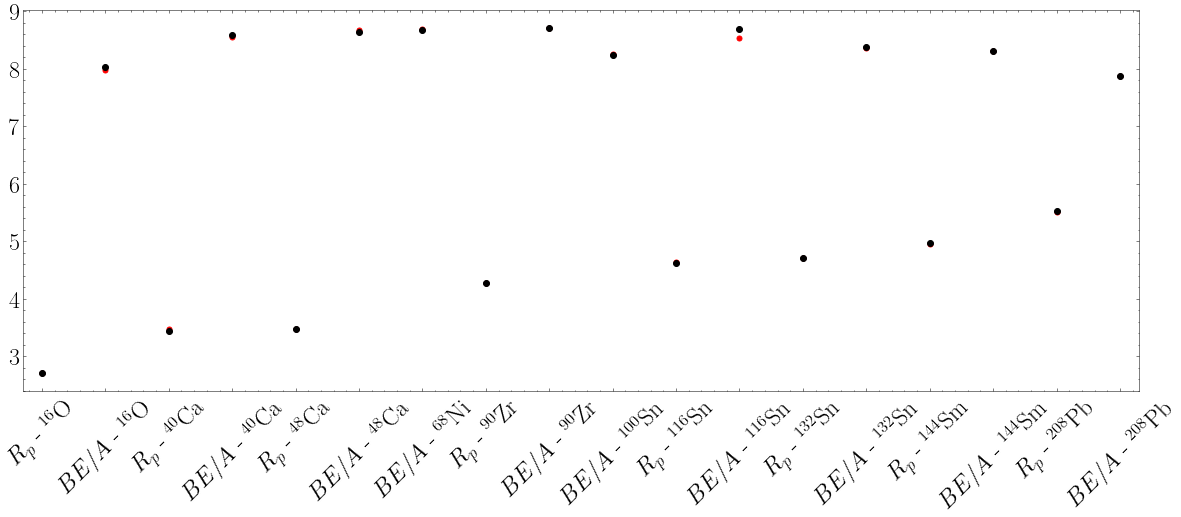

In [27]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]

cal = cal_1
print(cal.theta.mean().shape)
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
shift=0
cal_theta = cal.theta.rnd(1000) 
print(cal.theta.mean())
print(cal.theta.var())
# print(cal_theta[:10])

#cal_theta = cal_theta*(theta_range[1] - theta_range[0]) + theta_range[0]  
axs[0].plot(cal_theta)
axs[1-shift].boxplot(cal_theta)
axs[1-shift].set_xticks([1,2,3,4,5,6,7,8])
axs[1-shift].set_xticklabels(['$M_s$','$K_f$',r'$\frac{BE}{A}$','$M^*$','$K$','$\zeta$','$J$','$L$'])
axs[2-shift].hist(cal_theta[:,7])
#axs[2-shift].text(55,200,"L",fontdict={'size':40})
#axs[2-shift].set_title("$^{48}$Ca",fontsize=40)
post = cal.predict()
rndm_m = post.rnd(s = 1000)
# rndm_m = rbm_handler(x, cal_theta).T
#print(rndm_m[:10])
fig, naxs = plt.subplots(1, 1, figsize=(20, 7))
median = np.percentile(rndm_m, 50, axis = 0)
upper = np.abs(np.percentile(rndm_m, 97.5, axis = 0)-median)
# print(upper)
lower = np.abs(np.percentile(rndm_m, 2.5, axis = 0)-median)
naxs.errorbar(x,median, yerr=[lower,upper], marker="o",color = 'black',linestyle="None")
# axs[3].fill_between(xrep[0:2].reshape(2), lower[0:2], upper[0:2], color = 'grey')
naxs.plot(x, y, 'ro', markersize = 5, color='red')
naxs.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
naxs.set_xticklabels(['$R_p$ - $^{16}$O','$BE/A$ - $^{16}$O',
'$R_p$ - $^{40}$Ca','$BE/A$ - $^{40}$Ca',
'$R_p$ - $^{48}$Ca','$BE/A$ - $^{48}$Ca',
'$BE/A$ - $^{68}$Ni',
'$R_p$ - $^{90}$Zr','$BE/A$ - $^{90}$Zr',
'$BE/A$ - $^{100}$Sn',
'$R_p$ - $^{116}$Sn','$BE/A$ - $^{116}$Sn',
'$R_p$ - $^{132}$Sn','$BE/A$ - $^{132}$Sn',
'$R_p$ - $^{144}$Sm','$BE/A$ - $^{144}$Sm',
'$R_p$ - $^{208}$Pb','$BE/A$ - $^{208}$Pb'],rotation=45)
naxs.set_xlim([0.7,18.3])
# plt.draw()
# naxs.set_xticklabels(naxs.get_xticklabels(),rotation=45)
plt.show()

(1000, 8)


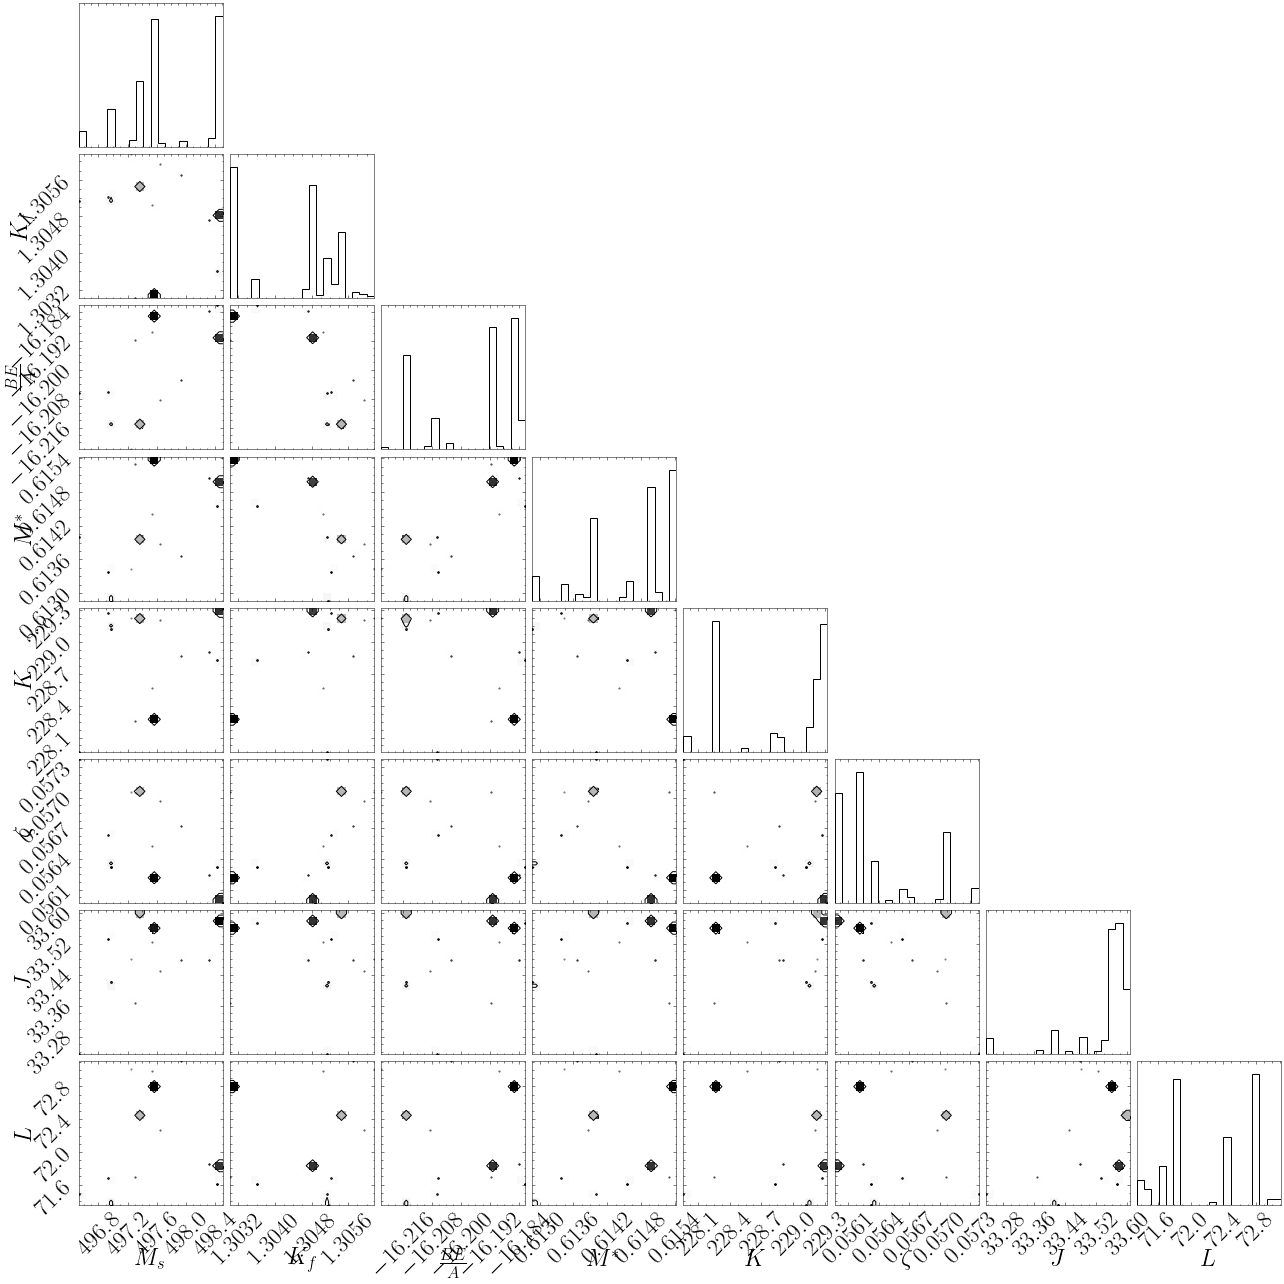

In [51]:
# import corner
print(cal.info['thetarnd'].shape)

#samples = np.random.randn(ndim * nsamples).reshape([nsamples, ndim])
figure = corner.corner(cal.info['thetarnd'],
    labels=['$M_s$','$K_f$',r'$\frac{BE}{A}$','$M^*$','$K$','$\zeta$','$J$','$L$'])

In [5]:

x = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])


y = np.array([2.686880131,7.976206,
              3.468162627,8.551303,
              3.467580495,8.666689,
              8.68247,
              4.261703839,8.70998,
              8.25300,
              4.61784199,8.523116,
              4.702334834,8.354852,
              4.945755879,8.303678,
              5.495181194,7.86745,
              ])
yerr = np.array([0.0134,0.0028,
              0.0034,0.0014,
              0.0027,0.0042,
              0.0007,
              0.0019,0.0028,
              0.0028,
              0.0043,0.0039,
              0.0007,0.0008,
              0.0026,0.00005,
              0.0018,0.0018,
              ])
obsvar = np.maximum(1.0*np.square(y*yerr),1e-5)
print(obsvar)

caldir = os.path.join(os.getcwd(), "Cal-"+datetime.datetime.now().strftime('%Y-%m-%d_%H-%M'))
os.makedirs(caldir, exist_ok=True)


numsamp = 2000
numchains=12

test_params = np.zeros((numchains,8))

rbm = emulator(x=x, theta=test_params, passthroughfunc=rbm_driver)

shift = 20
df = pd.read_csv("Sampling.out", delim_whitespace=True)
print(test_params.shape)
for i in range(numchains):
    test_params[i,0] = df["Ms"].iloc[i+shift]
    # test_params[1] = 782.5
    # test_params[2] = 763.0
    test_params[i,1] = df["kF"].iloc[i+shift]
    test_params[i,2] = df["BE"].iloc[i+shift]
    test_params[i,3] = df["M*"].iloc[i+shift]
    test_params[i,4] = df["K"].iloc[i+shift]
    test_params[i,5] = df["Zeta"].iloc[i+shift]
    test_params[i,6] = df["J"].iloc[i+shift]
    test_params[i,7] = df["L"].iloc[i+shift]
    test_params[i,:] = np.array([497.479,  1.3061, -16.28,   0.593, 238.0, 0.0256,  37.62,  112.8])

test_params[0,:] = np.array([497.479,  1.3061, -16.28,   0.593, 238.0, 0.0256,  37.62,  112.8])


numcal = range(numchains)
with Pool(12) as p:
    theta_array = p.starmap(calibration_runner,zip(repeat(rbm),repeat(y),repeat(obsvar),test_params,repeat(numsamp),numcal,repeat(caldir)))



[1.29630197e-03 4.98779719e-04 1.39045437e-04 1.43324575e-04
 8.76557946e-05 1.32496683e-03 3.69387898e-05 6.55652518e-05
 5.94771813e-04 5.33998151e-04 3.94289351e-04 1.10490773e-03
 1.08348569e-05 4.46742732e-05 1.65352988e-04 1.00000000e-05
 9.78383330e-05 2.00545533e-04]
(12, 8)
0.3255
0.331
0.291
0.323
0.3295
0.3105
0.2845
0.291
0.2915
0.278
0.31
0.3245


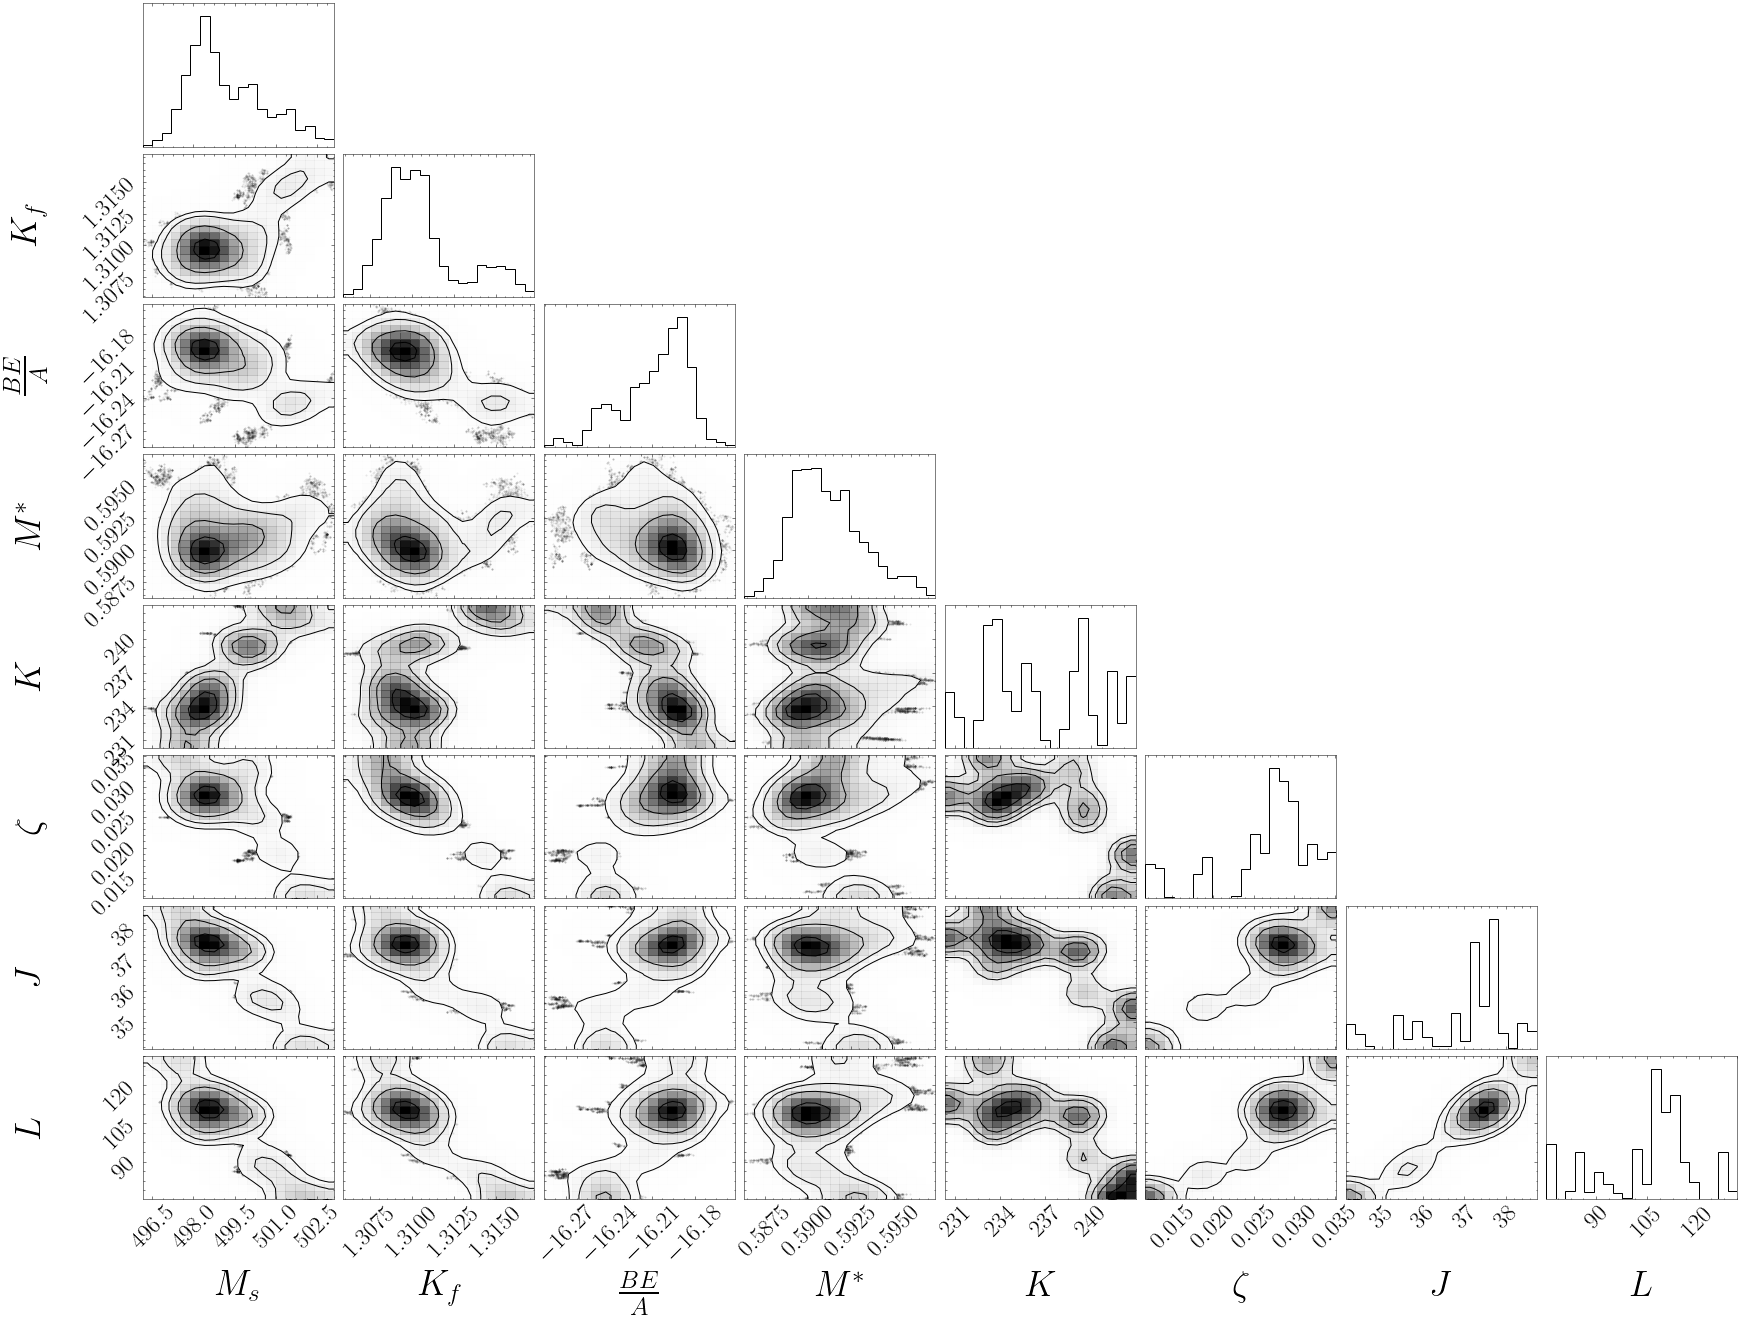

In [8]:
#label_kwargs

all_chains = np.zeros((numsamp*numchains,8))

# for i in range(numchains):
#     calfile = "caltheta_{}.out".format(i)
#     all_chains[i*numsamp:i*numsamp+numsamp,:] = np.loadtxt(calfile)
# print(all_chains)
all_chains = theta_array[0]
for ical in theta_array[1:]:
    #print(ical.shape)
    all_chains = np.vstack((all_chains,ical,))
    

#samples = np.random.randn(ndim * nsamples).reshape([nsamples, ndim])
figure = corner.corner(all_chains,
    labels=['$M_s$','$K_f$',r'$\frac{BE}{A}$','$M^*$','$K$','$\zeta$','$J$','$L$'],
    labelpad=0.2,
    label_kwargs={"fontsize":36},
    quantiles=None,
    smooth=(1.7),)
    # smooth1d=1.0)


width = 24
height = 18
figure.set_size_inches(width, height)

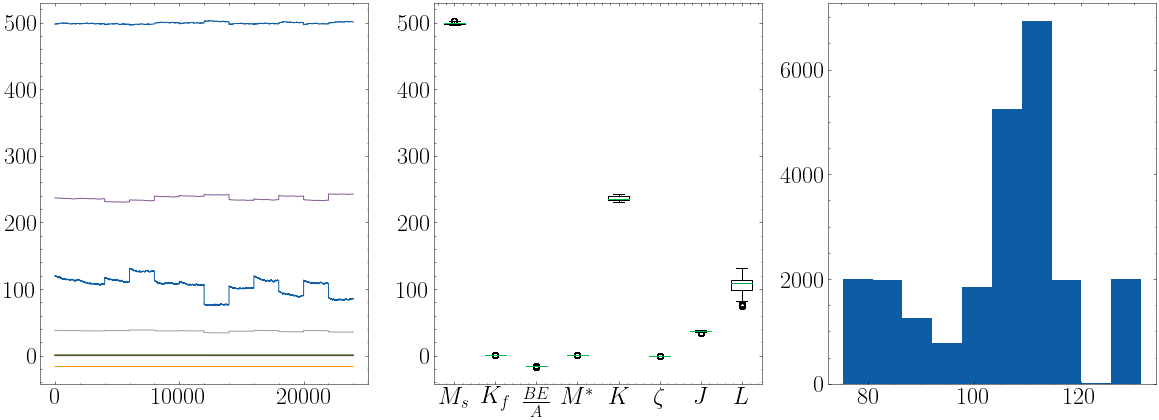

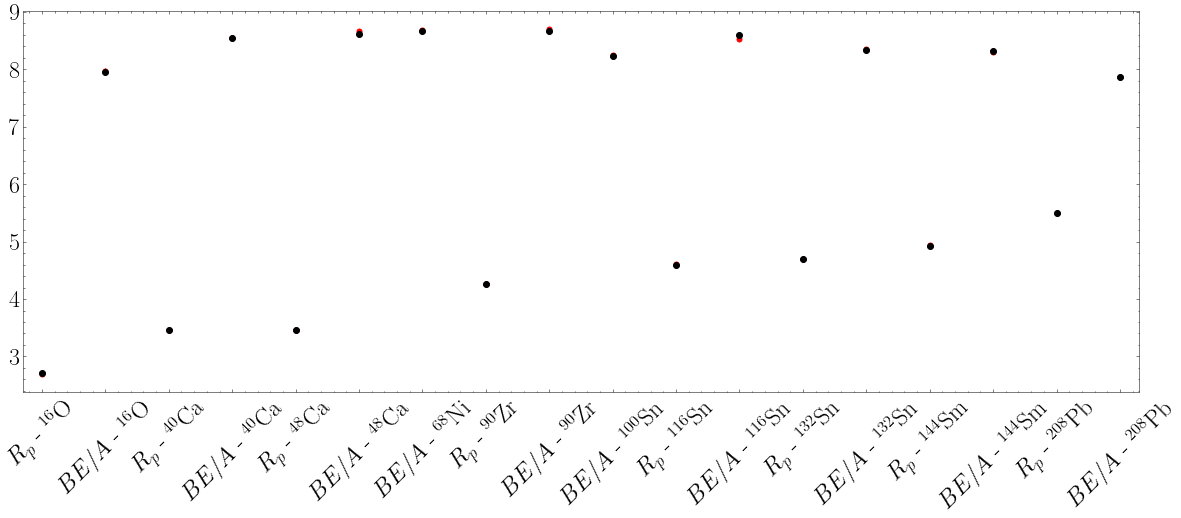

In [7]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]

fig, axs = plt.subplots(1, 3, figsize=(20, 7))
#cal_theta = cal_theta*(theta_range[1] - theta_range[0]) + theta_range[0]  
axs[0].plot(all_chains)
axs[1].boxplot(all_chains)
axs[1].set_xticks([1,2,3,4,5,6,7,8])
axs[1].set_xticklabels(['$M_s$','$K_f$',r'$\frac{BE}{A}$','$M^*$','$K$','$\zeta$','$J$','$L$'])
axs[2].hist(all_chains[:,7])
#axs[2-shift].text(55,200,"L",fontdict={'size':40})
#axs[2-shift].set_title("$^{48}$Ca",fontsize=40)
# post = cal.predict()
# rndm_m = post.rnd(s = 1000)
rng = np.random.default_rng()
theta_rand = rng.choice(all_chains,(1000),replace=False)
rndm_m = rbm_driver(x, theta_rand).T
#print(rndm_m[:10])
fig, naxs = plt.subplots(1, 1, figsize=(20, 7))
median = np.percentile(rndm_m, 50, axis = 0)
upper = np.abs(np.percentile(rndm_m, 97.5, axis = 0)-median)
# print(upper)
lower = np.abs(np.percentile(rndm_m, 2.5, axis = 0)-median)
naxs.errorbar(x,median, yerr=[lower,upper], marker="o",color = 'black',linestyle="None")
# axs[3].fill_between(xrep[0:2].reshape(2), lower[0:2], upper[0:2], color = 'grey')
naxs.plot(x, y, 'ro', markersize = 5, color='red')
naxs.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
naxs.set_xticklabels(['$R_p$ - $^{16}$O','$BE/A$ - $^{16}$O',
'$R_p$ - $^{40}$Ca','$BE/A$ - $^{40}$Ca',
'$R_p$ - $^{48}$Ca','$BE/A$ - $^{48}$Ca',
'$BE/A$ - $^{68}$Ni',
'$R_p$ - $^{90}$Zr','$BE/A$ - $^{90}$Zr',
'$BE/A$ - $^{100}$Sn',
'$R_p$ - $^{116}$Sn','$BE/A$ - $^{116}$Sn',
'$R_p$ - $^{132}$Sn','$BE/A$ - $^{132}$Sn',
'$R_p$ - $^{144}$Sm','$BE/A$ - $^{144}$Sm',
'$R_p$ - $^{208}$Pb','$BE/A$ - $^{208}$Pb'],rotation=45)
naxs.set_xlim([0.7,18.3])
# plt.draw()
# naxs.set_xticklabels(naxs.get_xticklabels(),rotation=45)
plt.show()